# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
Должна быть построена модель, которая по фотографии определит приблизительный возраст человека. 

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50 

Загружу csv-файл: 

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

Посмотрю на размер выборки и основную информацию:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
df.shape

(7591, 2)

In [5]:
df.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


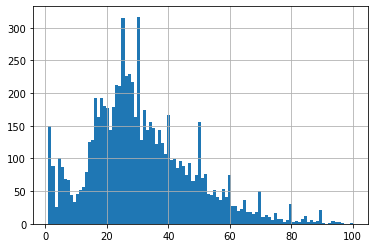

In [6]:
 df['real_age'].hist(bins=100)

На графике видна небольшая бимодальность. Скорее всего, смешаны две выборки в данных. Т.е. есть некий признак, который делает гарфик двугорбым (например, школьники и остальные, т.е. выборка была взята не случайная). Мало пожилых людей — модель плохо обучится на эту категорию покупателей. Есть младенцы, есть 100-летние — надо посмотерть на эти фото, что там за люди.

Напечатаю несколько изображений:

In [7]:
def load_train(df, path):
    
    train_datagen = ImageDataGenerator(
        #validation_split=0.25,
        rescale=1./255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        df,
        path,
        x_col = 'file_name',
        y_col = 'real_age',
        batch_size=16,
        class_mode='raw'
    )
 
    return train_datagen_flow

In [8]:
features_train, target_train = next(load_train(df, '/datasets/faces/final_files'))

Found 7591 validated image filenames.


Выведу 16 изображений:

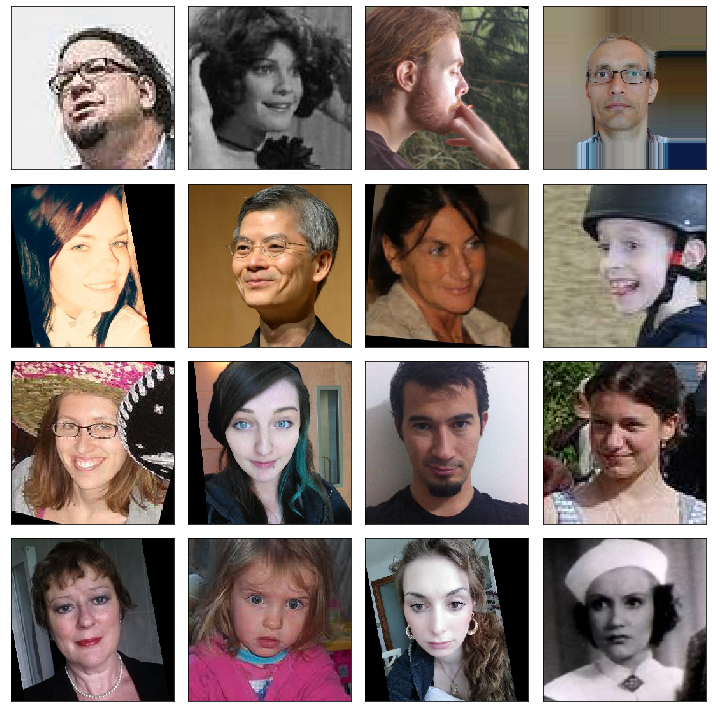

In [9]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features_train[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Исследовательский анализ показал, что в выборке присутствуют очень молодые люди, которые не могут являться клиентами. Возможно, стоит очистить выборку от таких фотографий, чтобы не тратить ресурсы впустую.  
Видно, что фотографии выровнены, скорее всего по уровню глаз, лица на фото центрированы, что облегчит задачу обучения, но может негативно сказаться на способности нейросети предсказывать возраст на реальных фото. При наличии ресурса, стоит уделить внимание аугментации изображений.

Особенности, которые заметны:

1. В датасете есть старые и черно-белые фотографии. Имеет смысл делать аугментацию с тем, чтобы делать фотографию черно-белой в некотором проценте случаев (этого нет в стандартном наборе). Возможно, стоит подкрутить цветовые каналы или яркость.

2. В датасете есть фотогарафи, на которых лица изображены под разными углами к вертикальной оси. Имеет смысл делать аугментацию с `rotation_range` равным +/- 15-20 градусов в некотором проценте случаев. Поворачивать само изображение и/или объект отдельно от фона.

3. В датасете есть фотогарафии, на которых лица изображены в полупрофиль. Имеет смысл делать аугментацию с отражением по горизонтали в некотором проценте случаев.

4. В датасете есть фотогарафи с разным разрешением. Имеет смысл делать аугментацию с изменением контрастности изображения в некотором проценте случаев.

5. В датасете есть фотогарафи, на которых изображены не лица, а голова и часть туловища (иногда человек полностью). Имеет смысл делать аугментацию с обезкой и масштабированием изображения в некотором проценте случаев, чтобы на фото были только лица примерно одного масштаба.

## Обучение модели

Ниже написанные функции и результат, обучение проводилось в облаке.

In [ ]:
def load_train(path):
    image_path = path + '/final_files'
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       horizontal_flip=True,
                                       shear_range = 0.2, # почти не влияет на метрику
                                       rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=image_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):

    image_path = path + '/final_files'
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=image_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    # замораживаем ResNet50 без верхушки
    backbone.trainable = True
    model = Sequential()
    model.add(backbone)
    # добавляем последние слои
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=21,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2
             )
    return model

результат вывода:

2022-01-16 18:07:27.079789: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-01-16 18:07:27.081512: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-01-16 18:07:27.891835: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-01-16 18:07:28.560796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-16 18:07:28.560879: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-16 18:07:28.560913: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-16 18:07:28.562595: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-01-16 18:07:28.562985: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-01-16 18:07:28.565192: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-01-16 18:07:28.566358: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-01-16 18:07:28.566425: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-01-16 18:07:28.570589: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-01-16 18:07:28.570927: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-01-16 18:07:28.577716: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-01-16 18:07:28.578128: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x45e0b90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-16 18:07:28.578155: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-01-16 18:07:28.719213: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4666bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-01-16 18:07:28.719251: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-01-16 18:07:28.721579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-16 18:07:28.721648: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-16 18:07:28.721659: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-16 18:07:28.721693: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-01-16 18:07:28.721705: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-01-16 18:07:28.721717: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-01-16 18:07:28.721728: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-01-16 18:07:28.721737: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-01-16 18:07:28.726177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-01-16 18:07:28.726245: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-16 18:07:29.029268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-01-16 18:07:29.029327: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-01-16 18:07:29.029335: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-01-16 18:07:29.033993: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/21
2022-01-16 18:07:39.464399: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-16 18:07:39.894116: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 92s - loss: 235.1468 - mean_absolute_error: 11.6733 - val_loss: 381.5803 - val_mean_absolute_error: 14.6051
Epoch 2/21
178/178 - 85s - loss: 152.1570 - mean_absolute_error: 9.4671 - val_loss: 298.3845 - val_mean_absolute_error: 12.8547
Epoch 3/21
178/178 - 85s - loss: 124.1497 - mean_absolute_error: 8.5192 - val_loss: 321.2908 - val_mean_absolute_error: 13.2585
Epoch 4/21
178/178 - 85s - loss: 109.1291 - mean_absolute_error: 7.9838 - val_loss: 309.5781 - val_mean_absolute_error: 12.9460
Epoch 5/21
178/178 - 85s - loss: 92.5537 - mean_absolute_error: 7.2974 - val_loss: 196.4595 - val_mean_absolute_error: 10.5303
Epoch 6/21
178/178 - 85s - loss: 85.2353 - mean_absolute_error: 7.0471 - val_loss: 107.4293 - val_mean_absolute_error: 7.8497
Epoch 7/21
178/178 - 85s - loss: 71.8452 - mean_absolute_error: 6.5233 - val_loss: 100.9677 - val_mean_absolute_error: 7.8409
Epoch 8/21
178/178 - 85s - loss: 65.2518 - mean_absolute_error: 6.2163 - val_loss: 125.9459 - val_mean_absolute_error: 8.9009
Epoch 9/21
178/178 - 85s - loss: 52.0496 - mean_absolute_error: 5.5630 - val_loss: 103.4476 - val_mean_absolute_error: 7.7551
Epoch 10/21
178/178 - 85s - loss: 46.5554 - mean_absolute_error: 5.2567 - val_loss: 150.5731 - val_mean_absolute_error: 9.1596
Epoch 11/21
178/178 - 85s - loss: 39.8083 - mean_absolute_error: 4.9063 - val_loss: 106.0091 - val_mean_absolute_error: 8.1258
Epoch 12/21
178/178 - 85s - loss: 33.0543 - mean_absolute_error: 4.4108 - val_loss: 105.9326 - val_mean_absolute_error: 7.9209
Epoch 13/21
178/178 - 86s - loss: 29.9258 - mean_absolute_error: 4.2640 - val_loss: 92.7577 - val_mean_absolute_error: 7.5035
Epoch 14/21
178/178 - 85s - loss: 26.0235 - mean_absolute_error: 3.9404 - val_loss: 105.0245 - val_mean_absolute_error: 7.8573
Epoch 15/21
178/178 - 85s - loss: 24.0109 - mean_absolute_error: 3.7603 - val_loss: 96.0106 - val_mean_absolute_error: 7.4645
Epoch 16/21
178/178 - 85s - loss: 20.9229 - mean_absolute_error: 3.5145 - val_loss: 109.6686 - val_mean_absolute_error: 8.1810
Epoch 17/21
178/178 - 85s - loss: 18.4519 - mean_absolute_error: 3.3393 - val_loss: 83.4098 - val_mean_absolute_error: 6.9044
Epoch 18/21
178/178 - 85s - loss: 15.9221 - mean_absolute_error: 3.0834 - val_loss: 84.8874 - val_mean_absolute_error: 6.8952
Epoch 19/21
178/178 - 85s - loss: 13.9563 - mean_absolute_error: 2.8836 - val_loss: 79.8725 - val_mean_absolute_error: 6.7465
Epoch 20/21
178/178 - 85s - loss: 13.9417 - mean_absolute_error: 2.8904 - val_loss: 80.6238 - val_mean_absolute_error: 6.7324
Epoch 21/21
178/178 - 85s - loss: 13.6411 - mean_absolute_error: 2.8473 - val_loss: 94.2609 - val_mean_absolute_error: 7.4041
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 94.2609 - mean_absolute_error: 7.4041
Test MAE: 7.4041
2022-01-16 18:07:27.079789: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-01-16 18:07:27.081512: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-01-16 18:07:27.891835: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-01-16 18:07:28.560796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-16 18:07:28.560879: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-16 18:07:28.560913: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-16 18:07:28.562595: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-01-16 18:07:28.562985: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-01-16 18:07:28.565192: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-01-16 18:07:28.566358: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-01-16 18:07:28.566425: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-01-16 18:07:28.570589: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-01-16 18:07:28.570927: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-01-16 18:07:28.577716: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-01-16 18:07:28.578128: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x45e0b90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-16 18:07:28.578155: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-01-16 18:07:28.719213: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4666bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-01-16 18:07:28.719251: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-01-16 18:07:28.721579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-16 18:07:28.721648: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-16 18:07:28.721659: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-16 18:07:28.721693: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-01-16 18:07:28.721705: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-01-16 18:07:28.721717: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-01-16 18:07:28.721728: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-01-16 18:07:28.721737: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-01-16 18:07:28.726177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-01-16 18:07:28.726245: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-16 18:07:29.029268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-01-16 18:07:29.029327: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-01-16 18:07:29.029335: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-01-16 18:07:29.033993: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/21
2022-01-16 18:07:39.464399: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-16 18:07:39.894116: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 92s - loss: 235.1468 - mean_absolute_error: 11.6733 - val_loss: 381.5803 - val_mean_absolute_error: 14.6051
Epoch 2/21
178/178 - 85s - loss: 152.1570 - mean_absolute_error: 9.4671 - val_loss: 298.3845 - val_mean_absolute_error: 12.8547
Epoch 3/21
178/178 - 85s - loss: 124.1497 - mean_absolute_error: 8.5192 - val_loss: 321.2908 - val_mean_absolute_error: 13.2585
Epoch 4/21
178/178 - 85s - loss: 109.1291 - mean_absolute_error: 7.9838 - val_loss: 309.5781 - val_mean_absolute_error: 12.9460
Epoch 5/21
178/178 - 85s - loss: 92.5537 - mean_absolute_error: 7.2974 - val_loss: 196.4595 - val_mean_absolute_error: 10.5303
Epoch 6/21
178/178 - 85s - loss: 85.2353 - mean_absolute_error: 7.0471 - val_loss: 107.4293 - val_mean_absolute_error: 7.8497
Epoch 7/21
178/178 - 85s - loss: 71.8452 - mean_absolute_error: 6.5233 - val_loss: 100.9677 - val_mean_absolute_error: 7.8409
Epoch 8/21
178/178 - 85s - loss: 65.2518 - mean_absolute_error: 6.2163 - val_loss: 125.9459 - val_mean_absolute_error: 8.9009
Epoch 9/21
178/178 - 85s - loss: 52.0496 - mean_absolute_error: 5.5630 - val_loss: 103.4476 - val_mean_absolute_error: 7.7551
Epoch 10/21
178/178 - 85s - loss: 46.5554 - mean_absolute_error: 5.2567 - val_loss: 150.5731 - val_mean_absolute_error: 9.1596
Epoch 11/21
178/178 - 85s - loss: 39.8083 - mean_absolute_error: 4.9063 - val_loss: 106.0091 - val_mean_absolute_error: 8.1258
Epoch 12/21
178/178 - 85s - loss: 33.0543 - mean_absolute_error: 4.4108 - val_loss: 105.9326 - val_mean_absolute_error: 7.9209
Epoch 13/21
178/178 - 86s - loss: 29.9258 - mean_absolute_error: 4.2640 - val_loss: 92.7577 - val_mean_absolute_error: 7.5035
Epoch 14/21
178/178 - 85s - loss: 26.0235 - mean_absolute_error: 3.9404 - val_loss: 105.0245 - val_mean_absolute_error: 7.8573
Epoch 15/21
178/178 - 85s - loss: 24.0109 - mean_absolute_error: 3.7603 - val_loss: 96.0106 - val_mean_absolute_error: 7.4645
Epoch 16/21
178/178 - 85s - loss: 20.9229 - mean_absolute_error: 3.5145 - val_loss: 109.6686 - val_mean_absolute_error: 8.1810
Epoch 17/21
178/178 - 85s - loss: 18.4519 - mean_absolute_error: 3.3393 - val_loss: 83.4098 - val_mean_absolute_error: 6.9044
Epoch 18/21
178/178 - 85s - loss: 15.9221 - mean_absolute_error: 3.0834 - val_loss: 84.8874 - val_mean_absolute_error: 6.8952
Epoch 19/21
178/178 - 85s - loss: 13.9563 - mean_absolute_error: 2.8836 - val_loss: 79.8725 - val_mean_absolute_error: 6.7465
Epoch 20/21
178/178 - 85s - loss: 13.9417 - mean_absolute_error: 2.8904 - val_loss: 80.6238 - val_mean_absolute_error: 6.7324
Epoch 21/21
178/178 - 85s - loss: 13.6411 - mean_absolute_error: 2.8473 - val_loss: 94.2609 - val_mean_absolute_error: 7.4041
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 94.2609 - mean_absolute_error: 7.4041
Test MAE: 7.4041

## Анализ обученной модели

Проанализирован набор фотографий людей с указанием возраста при помощи компьютерного зрения с привлечением готовых нейронных сетей и библиотеки Keras.

На тестовой выборке модель распознаёт фрукты с точностью 99.99%, что очень хорошо. В процессе обучения на разных эпохах точность колебалась от 90.5% (только на 6 эпохе из 7) до 99.9%, что говорит о важность подбора правильных параметров. Для высокой точности было бы достаточно 3 эпох с таким learning_rate (0.0001), так что можно было сэкономить ресурс GPU.